# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# I run the above unzip command many times so we cant see the output properly.

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import Resize, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size), ToTensor(), Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])]

    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, directory: str, transform: Callable = None, extension: str = '.jpg'):
        self.directory = directory
        self.transform = transform
        self.extension = extension
        self.img = []
        for i in glob(directory + "/*" + extension):
            self.img.append(i.rstrip())


    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.img)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        return self.transform(Image.open(self.img[index]))

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

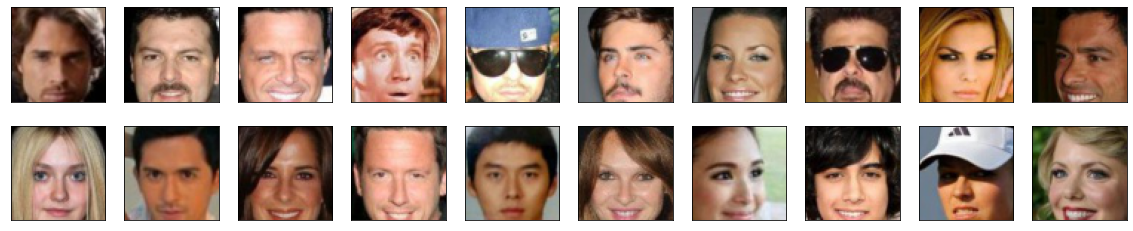

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch.nn as nn

In [8]:
# I used DCGAN discriminator architecture from pytorch documentation.

nc = 3
ndf = 64

class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x =  self.main(x) 
        # TODO: implement the forward method
        return x 

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [10]:
# I used DCGAN generator architecture from pytorch documentation.

ngf = 64

class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 64 x 64
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x =  self.main(x)
        # TODO: implement the forward method
        return x

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [12]:
# Learning rate
lr = 0.0002

# Beta1 hyperparameter
beta1 = 0.5

import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [13]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss
    
    # Binary Cross Entropy Loss function
    criterion = nn.BCELoss()
    
    #creates tensor for images with labels and stores to cuda
    label = torch.full((fake_logits.size(0),), 1.0, dtype=torch.float).cuda()
    loss = criterion(fake_logits,label)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [14]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss
    
    # Binary Cross Entropy Loss function
    criterion = nn.BCELoss()
    # Store fake and real images in tensors and stores to cuda
    label_real = torch.full((fake_logits.size(0),), 1.0, dtype=torch.float).cuda()
    label_fake = torch.full((fake_logits.size(0),), 0.0, dtype=torch.float).cuda()
    
    #loss for real images
    loss_real = criterion(real_logits,label_real)
    
    #loss for fake images from produced fromgenerator
    loss_fake = criterion(fake_logits,label_fake)
    
    return (loss_real + loss_fake) / 2.0

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [15]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [16]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    generator.zero_grad()
    noises = lambda x: torch.randn((x, latent_dim,1,1), device=device)
    latent_vector = noises(batch_size)
    generated_out = generator(latent_vector)
    class_out = discriminator(generated_out)
    g_loss = generator_loss(class_out.view(-1)) 
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    discriminator.zero_grad()
    noises = lambda x: torch.randn((x, latent_dim,1,1), device=device)
    real_pred = discriminator(real_images)
    
    latent_vector = noises(batch_size)
    with torch.no_grad():
            fake_img = generator(latent_vector)
    fake_pred = discriminator(fake_img)
    gp = None
    d_loss =  discriminator_loss(real_pred.view(-1),fake_pred.view(-1) )
    d_loss.backward()
    d_optimizer.step()
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [17]:
from datetime import datetime

In [18]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [19]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [20]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2022-09-17 00:28:24 | Epoch [1/10] | Batch 0/509 | d_loss: 0.7134 | g_loss: 1.8339
2022-09-17 00:28:39 | Epoch [1/10] | Batch 50/509 | d_loss: 0.0192 | g_loss: 12.5618
2022-09-17 00:28:54 | Epoch [1/10] | Batch 100/509 | d_loss: 0.0641 | g_loss: 5.7516
2022-09-17 00:29:09 | Epoch [1/10] | Batch 150/509 | d_loss: 0.7131 | g_loss: 2.7869
2022-09-17 00:29:24 | Epoch [1/10] | Batch 200/509 | d_loss: 0.1466 | g_loss: 3.7947
2022-09-17 00:29:39 | Epoch [1/10] | Batch 250/509 | d_loss: 0.1502 | g_loss: 3.2059
2022-09-17 00:29:53 | Epoch [1/10] | Batch 300/509 | d_loss: 0.1624 | g_loss: 4.0253
2022-09-17 00:30:08 | Epoch [1/10] | Batch 350/509 | d_loss: 0.1285 | g_loss: 4.0335
2022-09-17 00:30:23 | Epoch [1/10] | Batch 400/509 | d_loss: 0.1680 | g_loss: 4.3832
2022-09-17 00:30:38 | Epoch [1/10] | Batch 450/509 | d_loss: 0.1697 | g_loss: 4.3232
2022-09-17 00:30:53 | Epoch [1/10] | Batch 500/509 | d_loss: 0.1736 | g_loss: 4.9676


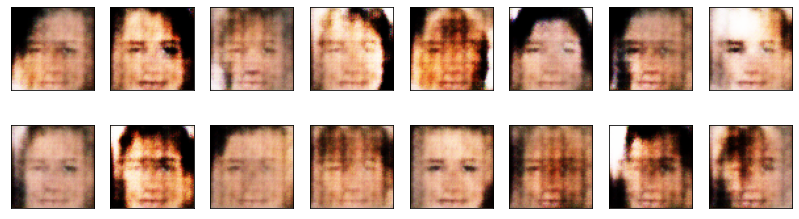

2022-09-17 00:30:57 | Epoch [2/10] | Batch 0/509 | d_loss: 0.7278 | g_loss: 5.0497
2022-09-17 00:31:12 | Epoch [2/10] | Batch 50/509 | d_loss: 1.0920 | g_loss: 5.9203
2022-09-17 00:31:27 | Epoch [2/10] | Batch 100/509 | d_loss: 0.0501 | g_loss: 4.0785
2022-09-17 00:31:42 | Epoch [2/10] | Batch 150/509 | d_loss: 0.1761 | g_loss: 4.1830
2022-09-17 00:31:57 | Epoch [2/10] | Batch 200/509 | d_loss: 0.1869 | g_loss: 5.2309
2022-09-17 00:32:12 | Epoch [2/10] | Batch 250/509 | d_loss: 0.1434 | g_loss: 4.9904
2022-09-17 00:32:27 | Epoch [2/10] | Batch 300/509 | d_loss: 0.2256 | g_loss: 4.7188
2022-09-17 00:32:42 | Epoch [2/10] | Batch 350/509 | d_loss: 0.1716 | g_loss: 3.0395
2022-09-17 00:32:57 | Epoch [2/10] | Batch 400/509 | d_loss: 0.4567 | g_loss: 6.8262
2022-09-17 00:33:12 | Epoch [2/10] | Batch 450/509 | d_loss: 0.2870 | g_loss: 5.4092
2022-09-17 00:33:27 | Epoch [2/10] | Batch 500/509 | d_loss: 0.2544 | g_loss: 4.8511


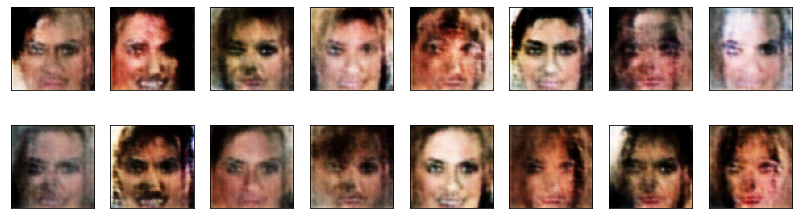

2022-09-17 00:33:31 | Epoch [3/10] | Batch 0/509 | d_loss: 0.2354 | g_loss: 3.3659
2022-09-17 00:33:46 | Epoch [3/10] | Batch 50/509 | d_loss: 0.3288 | g_loss: 5.3352
2022-09-17 00:34:01 | Epoch [3/10] | Batch 100/509 | d_loss: 0.1226 | g_loss: 4.9081
2022-09-17 00:34:16 | Epoch [3/10] | Batch 150/509 | d_loss: 0.2145 | g_loss: 3.2639
2022-09-17 00:34:30 | Epoch [3/10] | Batch 200/509 | d_loss: 0.1441 | g_loss: 3.7942
2022-09-17 00:34:45 | Epoch [3/10] | Batch 250/509 | d_loss: 0.2086 | g_loss: 3.6739
2022-09-17 00:35:00 | Epoch [3/10] | Batch 300/509 | d_loss: 0.1692 | g_loss: 3.9103
2022-09-17 00:35:15 | Epoch [3/10] | Batch 350/509 | d_loss: 0.2278 | g_loss: 3.4342
2022-09-17 00:35:30 | Epoch [3/10] | Batch 400/509 | d_loss: 0.4522 | g_loss: 6.7884
2022-09-17 00:35:45 | Epoch [3/10] | Batch 450/509 | d_loss: 0.3754 | g_loss: 2.6906
2022-09-17 00:36:00 | Epoch [3/10] | Batch 500/509 | d_loss: 0.2455 | g_loss: 5.0784


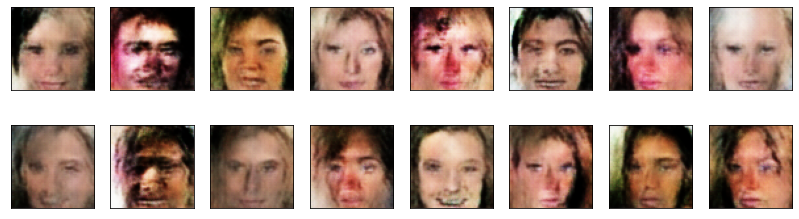

2022-09-17 00:36:04 | Epoch [4/10] | Batch 0/509 | d_loss: 0.4693 | g_loss: 4.7221
2022-09-17 00:36:19 | Epoch [4/10] | Batch 50/509 | d_loss: 0.1509 | g_loss: 2.7717
2022-09-17 00:36:34 | Epoch [4/10] | Batch 100/509 | d_loss: 0.2672 | g_loss: 5.4825
2022-09-17 00:36:49 | Epoch [4/10] | Batch 150/509 | d_loss: 0.4195 | g_loss: 2.6404
2022-09-17 00:37:04 | Epoch [4/10] | Batch 200/509 | d_loss: 0.1870 | g_loss: 1.7217
2022-09-17 00:37:19 | Epoch [4/10] | Batch 250/509 | d_loss: 0.3035 | g_loss: 5.4541
2022-09-17 00:37:34 | Epoch [4/10] | Batch 300/509 | d_loss: 0.2406 | g_loss: 4.4488
2022-09-17 00:37:49 | Epoch [4/10] | Batch 350/509 | d_loss: 0.1669 | g_loss: 4.7693
2022-09-17 00:38:04 | Epoch [4/10] | Batch 400/509 | d_loss: 0.1824 | g_loss: 4.1682
2022-09-17 00:38:19 | Epoch [4/10] | Batch 450/509 | d_loss: 0.2293 | g_loss: 4.5532
2022-09-17 00:38:34 | Epoch [4/10] | Batch 500/509 | d_loss: 0.2221 | g_loss: 4.3846


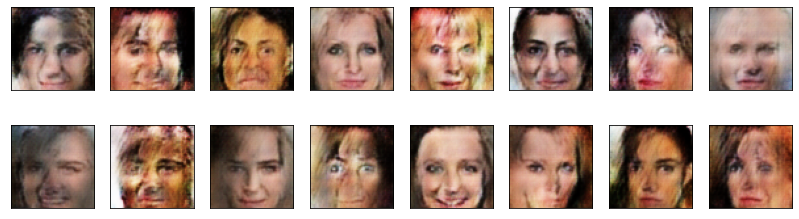

2022-09-17 00:38:38 | Epoch [5/10] | Batch 0/509 | d_loss: 0.1607 | g_loss: 5.1200
2022-09-17 00:38:53 | Epoch [5/10] | Batch 50/509 | d_loss: 0.2563 | g_loss: 2.8334
2022-09-17 00:39:08 | Epoch [5/10] | Batch 100/509 | d_loss: 0.1301 | g_loss: 3.8192
2022-09-17 00:39:23 | Epoch [5/10] | Batch 150/509 | d_loss: 0.1627 | g_loss: 3.1892
2022-09-17 00:39:38 | Epoch [5/10] | Batch 200/509 | d_loss: 0.2348 | g_loss: 2.4211
2022-09-17 00:39:53 | Epoch [5/10] | Batch 250/509 | d_loss: 0.2489 | g_loss: 4.2050
2022-09-17 00:40:08 | Epoch [5/10] | Batch 300/509 | d_loss: 0.1699 | g_loss: 3.5674
2022-09-17 00:40:23 | Epoch [5/10] | Batch 350/509 | d_loss: 0.1093 | g_loss: 3.0046
2022-09-17 00:40:38 | Epoch [5/10] | Batch 400/509 | d_loss: 0.1588 | g_loss: 5.1768
2022-09-17 00:40:53 | Epoch [5/10] | Batch 450/509 | d_loss: 0.1810 | g_loss: 4.1933
2022-09-17 00:41:08 | Epoch [5/10] | Batch 500/509 | d_loss: 0.0960 | g_loss: 3.8352


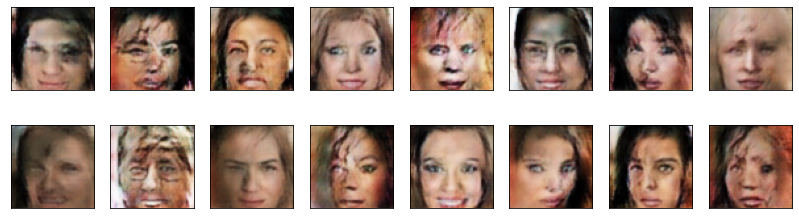

2022-09-17 00:41:11 | Epoch [6/10] | Batch 0/509 | d_loss: 0.0633 | g_loss: 3.2668
2022-09-17 00:41:26 | Epoch [6/10] | Batch 50/509 | d_loss: 0.2998 | g_loss: 1.6970
2022-09-17 00:41:41 | Epoch [6/10] | Batch 100/509 | d_loss: 1.9722 | g_loss: 2.7790
2022-09-17 00:41:56 | Epoch [6/10] | Batch 150/509 | d_loss: 0.1247 | g_loss: 4.6637
2022-09-17 00:42:11 | Epoch [6/10] | Batch 200/509 | d_loss: 0.2096 | g_loss: 4.3480
2022-09-17 00:42:26 | Epoch [6/10] | Batch 250/509 | d_loss: 0.1520 | g_loss: 3.3905
2022-09-17 00:42:41 | Epoch [6/10] | Batch 300/509 | d_loss: 0.0899 | g_loss: 4.4966
2022-09-17 00:42:56 | Epoch [6/10] | Batch 350/509 | d_loss: 0.2245 | g_loss: 3.1911
2022-09-17 00:43:11 | Epoch [6/10] | Batch 400/509 | d_loss: 0.0961 | g_loss: 3.7346
2022-09-17 00:43:26 | Epoch [6/10] | Batch 450/509 | d_loss: 0.0793 | g_loss: 3.9094
2022-09-17 00:43:41 | Epoch [6/10] | Batch 500/509 | d_loss: 0.1465 | g_loss: 3.9933


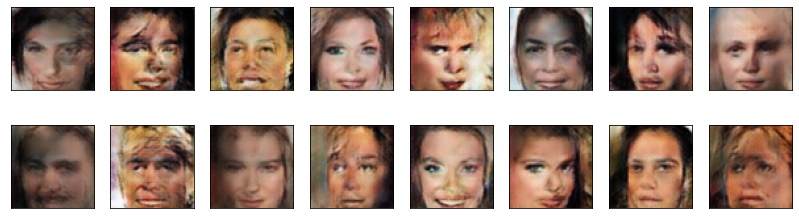

2022-09-17 00:43:45 | Epoch [7/10] | Batch 0/509 | d_loss: 0.7631 | g_loss: 0.6324
2022-09-17 00:44:00 | Epoch [7/10] | Batch 50/509 | d_loss: 0.1633 | g_loss: 5.1266
2022-09-17 00:44:15 | Epoch [7/10] | Batch 100/509 | d_loss: 0.4476 | g_loss: 3.5347
2022-09-17 00:44:30 | Epoch [7/10] | Batch 150/509 | d_loss: 0.6443 | g_loss: 6.4455
2022-09-17 00:44:45 | Epoch [7/10] | Batch 200/509 | d_loss: 0.2862 | g_loss: 4.4579
2022-09-17 00:45:00 | Epoch [7/10] | Batch 250/509 | d_loss: 0.1347 | g_loss: 1.9222
2022-09-17 00:45:15 | Epoch [7/10] | Batch 300/509 | d_loss: 0.1776 | g_loss: 4.2074
2022-09-17 00:45:30 | Epoch [7/10] | Batch 350/509 | d_loss: 0.1626 | g_loss: 2.1737
2022-09-17 00:45:45 | Epoch [7/10] | Batch 400/509 | d_loss: 0.1934 | g_loss: 3.8996
2022-09-17 00:45:59 | Epoch [7/10] | Batch 450/509 | d_loss: 0.1190 | g_loss: 2.1917
2022-09-17 00:46:14 | Epoch [7/10] | Batch 500/509 | d_loss: 0.4430 | g_loss: 3.4539


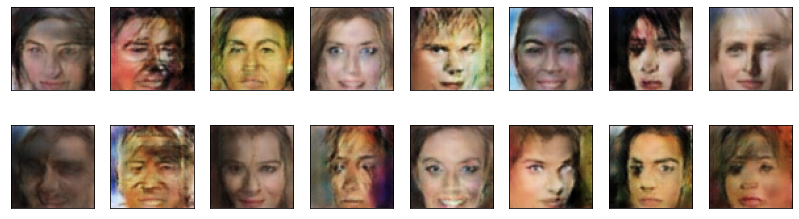

2022-09-17 00:46:18 | Epoch [8/10] | Batch 0/509 | d_loss: 0.3167 | g_loss: 5.2401
2022-09-17 00:46:33 | Epoch [8/10] | Batch 50/509 | d_loss: 0.1306 | g_loss: 5.3787
2022-09-17 00:46:48 | Epoch [8/10] | Batch 100/509 | d_loss: 0.1517 | g_loss: 2.2384
2022-09-17 00:47:03 | Epoch [8/10] | Batch 150/509 | d_loss: 0.5187 | g_loss: 8.1948
2022-09-17 00:47:18 | Epoch [8/10] | Batch 200/509 | d_loss: 0.2156 | g_loss: 1.7424
2022-09-17 00:47:33 | Epoch [8/10] | Batch 250/509 | d_loss: 0.1205 | g_loss: 4.8525
2022-09-17 00:47:48 | Epoch [8/10] | Batch 300/509 | d_loss: 0.1938 | g_loss: 4.7894
2022-09-17 00:48:03 | Epoch [8/10] | Batch 350/509 | d_loss: 0.1844 | g_loss: 6.4422
2022-09-17 00:48:18 | Epoch [8/10] | Batch 400/509 | d_loss: 0.9905 | g_loss: 7.0855
2022-09-17 00:48:33 | Epoch [8/10] | Batch 450/509 | d_loss: 0.0827 | g_loss: 3.7285
2022-09-17 00:48:48 | Epoch [8/10] | Batch 500/509 | d_loss: 0.0357 | g_loss: 2.3992


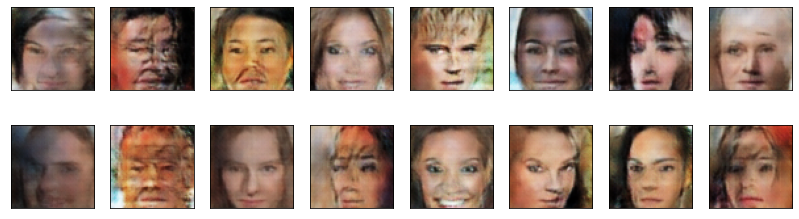

2022-09-17 00:48:52 | Epoch [9/10] | Batch 0/509 | d_loss: 0.0458 | g_loss: 5.0098
2022-09-17 00:49:07 | Epoch [9/10] | Batch 50/509 | d_loss: 0.0685 | g_loss: 4.7576
2022-09-17 00:49:22 | Epoch [9/10] | Batch 100/509 | d_loss: 0.0167 | g_loss: 3.7196
2022-09-17 00:49:37 | Epoch [9/10] | Batch 150/509 | d_loss: 0.0339 | g_loss: 2.3539
2022-09-17 00:49:52 | Epoch [9/10] | Batch 200/509 | d_loss: 0.0450 | g_loss: 4.1658
2022-09-17 00:50:07 | Epoch [9/10] | Batch 250/509 | d_loss: 0.0561 | g_loss: 5.5410
2022-09-17 00:50:22 | Epoch [9/10] | Batch 300/509 | d_loss: 0.0235 | g_loss: 4.8878
2022-09-17 00:50:37 | Epoch [9/10] | Batch 350/509 | d_loss: 0.0814 | g_loss: 3.9217
2022-09-17 00:50:52 | Epoch [9/10] | Batch 400/509 | d_loss: 0.0856 | g_loss: 4.8989
2022-09-17 00:51:07 | Epoch [9/10] | Batch 450/509 | d_loss: 0.3413 | g_loss: 8.5093
2022-09-17 00:51:22 | Epoch [9/10] | Batch 500/509 | d_loss: 0.0898 | g_loss: 4.3920


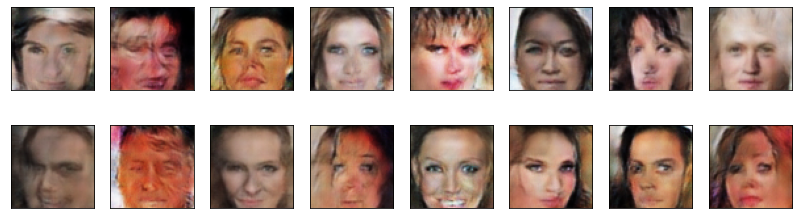

2022-09-17 00:51:25 | Epoch [10/10] | Batch 0/509 | d_loss: 0.3743 | g_loss: 8.2308
2022-09-17 00:51:40 | Epoch [10/10] | Batch 50/509 | d_loss: 0.8482 | g_loss: 6.9293
2022-09-17 00:51:55 | Epoch [10/10] | Batch 100/509 | d_loss: 0.0370 | g_loss: 3.9743
2022-09-17 00:52:10 | Epoch [10/10] | Batch 150/509 | d_loss: 0.1498 | g_loss: 5.1710
2022-09-17 00:52:25 | Epoch [10/10] | Batch 200/509 | d_loss: 0.0064 | g_loss: 5.0352
2022-09-17 00:52:40 | Epoch [10/10] | Batch 250/509 | d_loss: 0.0927 | g_loss: 5.2703
2022-09-17 00:52:55 | Epoch [10/10] | Batch 300/509 | d_loss: 0.0374 | g_loss: 4.0877
2022-09-17 00:53:10 | Epoch [10/10] | Batch 350/509 | d_loss: 0.0167 | g_loss: 4.9075
2022-09-17 00:53:25 | Epoch [10/10] | Batch 400/509 | d_loss: 0.1442 | g_loss: 3.9888
2022-09-17 00:53:40 | Epoch [10/10] | Batch 450/509 | d_loss: 0.0255 | g_loss: 4.8258
2022-09-17 00:53:55 | Epoch [10/10] | Batch 500/509 | d_loss: 0.0444 | g_loss: 6.8100


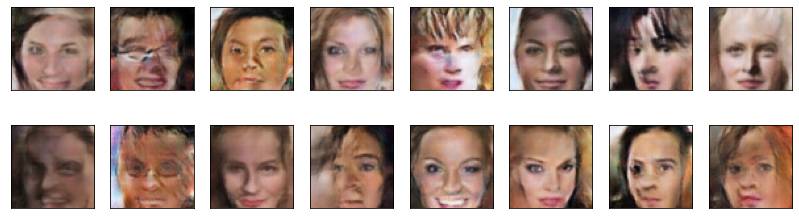

In [21]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        d_loss = discriminator_step(64,latent_dim,real_images)
        g_loss = generator_step(64,latent_dim)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

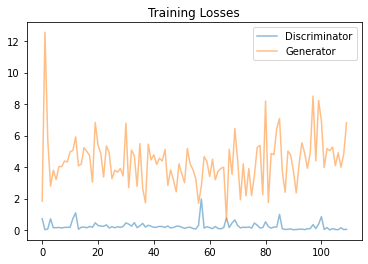

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

The dataset has a good size but i found almost similar color intesity in all the images that is not always the case in real world. 
Model size i.e. number of layers and parameters can have better scope to generate new images but it also needs high computaional efficiency. As i observed this data also takes time if we go for more deep network architecture.
Otptimizers effect the optimization of models. Optimization always improves model by searching better gradiant potential. "Higher the epochs and better accuracy" is significant upto some extent. So,optimum number of epochs like optimizers, learning rate and beta values should be used.
Loss function is one of most important step to assess the model quantitatively and followed by other important steps such as backpropagation and optimization untill it comes down. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.